<center>
<img src="https://i.pinimg.com/564x/e7/48/d2/e748d2bdcc1132ec0d427f6db7e833d6.jpg" width="600"> 

# Предсказываем количество слушателей на Яндекс Музыке
</center>

**ФИО:** Колесникова Анастасия Ильинична (241), Скуртул Надежда Анатольевна (257)

## Шаг 1: выбор темы

Тема уже была выбрана и подробно описана в форме, а также подробный порядок действий будет затрагиваться ниже, но общую суть проекта мы напомним здесь.

__Задача проекта:__ На основе кагловского датасета (https://www.kaggle.com/datasets/pieca111/music-artists-popularity), информации, собранной с API Яндекс музыки и английской википедии, обучить модель предсказывать количество прослушиваний на Яндекс Музыке у исполнителя.

## Шаг 2: сбор данных (максимум 20)

Импортируем необходимые библиотеки:

In [2]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tqdm.notebook import tqdm
from pprint import pprint

In [70]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import bs4
import re

In [111]:
# для красивых графиков

%config InlineBackend.figure_format = 'retina'

sns.set(style='darkgrid', palette='deep')

plt.rcParams['font.size'] = 16
plt.rcParams['savefig.format'] = 'pdf'

Теперь мы готовы начать работу.

<center>
<img src="https://i.pinimg.com/564x/ef/ce/fa/efcefa78296109467a6b1576c89d5a58.jpg" width="400"> 

</center>

## 0. Подгрузим готовый датасет с Kaggle и обработаем его

Подгрузим таблицу с Kaggle (ссылку смотри выше, также сам файл с датасетом прикрепим на ГитХабе отдельно). Удалим ненужную колонку 'mbid', так как она содержит id исполнителей с сайта musicbrainz, а мы будем делать предсказания на основе приложения Яндекс Музыка, а также столбцы 'artist_lastfm', 'country_lastfm', 'tags_mb', 'tags_lastfm', 'ambiguous_artist', так как они не представляют ценности при обучении нашей модели. Также удалим повторяющиеся группы.

In [106]:
df = pd.read_csv('C:/Users/Настя/Python Contests/artists.csv', sep=',')
df = df.drop(['mbid', 'artist_lastfm', 'country_lastfm', 'tags_mb', 'tags_lastfm', 'ambiguous_artist'], axis=1)
df.drop_duplicates(subset='artist_mb', inplace=True)
print(df.shape)
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2,4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(1352997, 4)


,artist_mb,country_mb,listeners_lastfm,scrobbles_lastfm
0,Coldplay,United Kingdom,5381567.0,360111850.0
1,Radiohead,United Kingdom,4732528.0,499548797.0
2,Red Hot Chili Peppers,United States,4620835.0,293784041.0
3,Rihanna,United States,4558193.0,199248986.0
4,Eminem,United States,4517997.0,199507511.0


Сначала мы предполагали не использовать колонки listeners_lastfm и scrobbles_lastfm и только выбрать по ним самых популярных исполнителей, но в итоге пришли к выводу, что прослушивания с иностранной платформы могут быть полезными при обучении модели.

In [ ]:
# df = pd.read_csv('C:/Users/Настя/Python Contests/artists.csv', sep=',')
# df = df.drop(['mbid', 'artist_lastfm', 'country_lastfm', 'tags_mb', 'scrobbles_lastfm', 'ambiguous_artist'], axis=1)
# df.drop_duplicates(subset='artist_mb', inplace=True)
# print(df.shape)
# df.head()

У нас огромное количество наблюдений (1352997, как видно из размера массива), поэтому работу с пропусками мы можем позволить себе ещё на этапе сбора данных. Удалим строки (исполнителей и группы) с хотя бы одной пустой ячейкой.

In [13]:
df = df.dropna()
print(df.shape)
df.head()

(420884, 4)


,artist_mb,country_mb,listeners_lastfm,scrobbles_lastfm
0,Coldplay,United Kingdom,5381567.0,360111850.0
1,Radiohead,United Kingdom,4732528.0,499548797.0
2,Red Hot Chili Peppers,United States,4620835.0,293784041.0
3,Rihanna,United States,4558193.0,199248986.0
4,Eminem,United States,4517997.0,199507511.0


В датафрейме мы с помощью колонки 'listeners_lastfm' отобрали из 420884 исполнителей, оставшихся после удаления строк с путями ячеками, 5000 самых популярных, с которыми мы будем работать на Яндекс Музыке (для облегчения работы с циклами в промежуточном вариенте использовали 1500, но в финальной версии работы оставим 5000). Мы можем выбрать популярных исполнителей так вместо того, чтобы выбрать самые популярные группы по данным Яндекс Музыки, так как такая выборка позволит нам обучить модель на группах, которые, возможно, не так популярны на российской платформе. Соответственно модель будет обучена и не не самых популярных в России группах и сможет лучше прогнозировать популярность исполнителя.

In [24]:
df = df.nlargest(1500, 'listeners_lastfm')

In [25]:
# df = df.drop('listeners_lastfm', axis=1)
print(df.shape)
df.head()

(1500, 4)


,artist_mb,country_mb,listeners_lastfm,scrobbles_lastfm
0,Coldplay,United Kingdom,5381567.0,360111850.0
1,Radiohead,United Kingdom,4732528.0,499548797.0
2,Red Hot Chili Peppers,United States,4620835.0,293784041.0
3,Rihanna,United States,4558193.0,199248986.0
4,Eminem,United States,4517997.0,199507511.0


У нас есть готовый список исполнителей, с которыми мы можем работать. Дальнейший порядок сбора данных:

1. С помощью Яндекс API подгрузим количество лайков (на основе которых и будем определять популярность исполнителя, так как на Яндекс Музыке указано только количество прослушиваний за последний месяц, а не накопительный эффект), количество треков и количество альбомов у исполнителя. 

2. Обратимся к англоязычной Википедии, спарсим с неё данные о каждом исполнителе: количество лет работы исполнителя или группы, создадим переменные, закодированные как 0 или 1, в зависимости от того, продолжает ли работать исполнитель на текущий момент, прерывала ли группа своё существование / исполнитель свою музыкальную карьеру.

Таким образом.

Что нужно достать с Яндекс API:
- количество лайков у исполнителя (наш таргет)
- количество треков
- количество альбомов

Что нужно достать с вики:
- сколько работает группа / исполнитель
- работает ли до сих пор (бинарная переменная)

__Да начнётся мясо.__

<center>
<img src="https://preview.redd.it/hcz8vstwwbx91.jpg?width=750&format=pjpg&auto=webp&v=enabled&s=edbaeae53873c98b34cabff57e0cbef7951add48" width="400"> 

</center>

## 1. Работаем с Яндекс API.

1.1. Установим Яндекс API и создадим экземпляр клиента. Мы инициализируем синхронного клиента, так как у нас нет необходимости в обработке большого количества запросов и не требуется высокая производительность. Также подгрузим наш токен.

In [9]:
pip install -U yandex-music

  Created wheel for yandex-music: filename=yandex_music-2.1.1-py3-none-any.whl size=296641 sha256=fd9e325bc1fd389dbd683523dedb72854b6b0a0562397763094e454d7f6f52b4
  Stored in directory: c:\users\настя\appdata\local\pip\cache\wheels\3a\72\d5\e20fa4ee4438959cac920ccbc680dcf2ac2a866f0d7dd14f9c
Successfully built yandex-music



In [8]:
from yandex_music import Client

client = Client('здесь нужно указать ваш токен :)').init()

Yandex Music API v2.1.1, Copyright (C) 2019-2023 Ilya (Marshal) <https://github.com/MarshalX>
Licensed under the terms of the GNU Lesser General Public License v3 (LGPLv3)



Здесь (в окне ниже) мы пытались разобраться, как достать необходимые нам признаки с помощью API. Здесь не представлены все наши страдания, но вы можете прочувствовать их, окунувшись в документацию, представленную по ссылке: https://yandex-music.readthedocs.io/en/main/index.html. Половина функций по какой-то причине не работает, а официальной постоянно обновляемой документации от Yandex, к сожалению, нет. 

Ниже представлен закоменченный шаг, когда мы всё-таки поняли, как добраться до информации исполнителей по API. 

In [107]:
# a = client.search("Rihanna")
# nirv_id = a.best.to_dict()['result']['id']

# # pprint([key for key in client.artistsBriefInfo(nirv_id).to_dict().keys()])
# # pprint(client.artistsBriefInfo(nirv_id).to_dict()['artist'])

# pprint(client.artistsBriefInfo(nirv_id).to_dict()['artist']['likes_count'])
# pprint(client.artistsBriefInfo(nirv_id).to_dict()['artist']['genres'])
# pprint(client.artistsBriefInfo(nirv_id).to_dict()['artist']['en_wikipedia_link'])

Дальше всю необходимую нам информацию мы получили для 5000 исполнителей с помощью цикла. Его выполнение занимает около 40 минут, возможно, мы постараемся усовершенствовать его в будущем.

In [26]:
artist_names = df['artist_mb'].tolist()

In [40]:
artist_track_counts = {}

for i in tqdm(artist_names):
    try:
        artist = client.search(i)
        artist_id = artist.best.to_dict()['result']['id']
        likes = client.artistsBriefInfo(artist_id).to_dict()['artist']['likes_count']
        tracks = client.artistsBriefInfo(artist_id).to_dict()['artist']['counts']['tracks']
        albums = client.artistsBriefInfo(artist_id).to_dict()['artist']['counts']['direct_albums']
        genres = client.artistsBriefInfo(artist_id).to_dict()['artist']['genres']
        wiki = client.artistsBriefInfo(artist_id).to_dict()['artist']['en_wikipedia_link']
        artist_track_counts[i] = likes, tracks, albums, genres, wiki
    except:
        print(f"Исполнитель {i} не найден")

  0%|          | 0/1500 [00:00<?, ?it/s]

Исполнитель Phoenix не найден
Исполнитель CAKE не найден
Исполнитель Neutral Milk Hotel не найден
Исполнитель The Temptations не найден
Исполнитель Stars не найден
Исполнитель Underworld не найден
Исполнитель Ratatat не найден
Исполнитель Poison не найден
Исполнитель +44 не найден
Исполнитель Free не найден
Исполнитель The Miracles не найден
Исполнитель ザ・ドリフターズ не найден
Исполнитель Girls не найден


In [108]:
# print(artist_track_counts)

Теперь нашей задачей было оформить новые данные из словаря в датафрейм. Для этого пришлось его немного повертеть.

In [66]:
df_yandex = pd.DataFrame(artist_track_counts)
df_yandex.head()

,Coldplay,Radiohead,Red Hot Chili Peppers,Rihanna,Eminem,The Killers,Kanye West,Nirvana,Muse,Queen,...,Kodaline,Benjamin Francis Leftwich,Bobby McFerrin,Bobby Womack,!!!,Gang of Four,Gentleman,Cary Brothers,Blood Red Shoes,Coconut Records
0,1285587,383038,2123125,1670335,5179686,373810,1981468,3500045,1033821,4431010,...,53252,846,35399,1933,432,11333,0,565,5302,273
1,186,200,266,268,396,151,386,165,149,297,...,60,87,175,318,14,102,0,50,52,34
2,60,42,32,57,37,25,51,15,35,38,...,0,22,13,46,5,18,0,12,10,3
3,[rock],[indie],[rock],"[pop, dance, rnb]",[foreignrap],"[alternative, rock, indie]",[foreignrap],"[rock, alternative]","[alternative, rock]","[rock, hardrock, films]",...,"[indie, techno]",[foreignbard],[vocaljazz],"[rnb, pop, soul]",[alternative],"[alternative, newwave, rock]",[],[foreignbard],"[rock, alternative, electronics]","[pop, films, punk]"
4,http://en.wikipedia.org/wiki/Coldplay,http://en.wikipedia.org/wiki/Radiohead,http://en.wikipedia.org/wiki/Red Hot Chili Pep...,http://en.wikipedia.org/wiki/Rihanna,http://en.wikipedia.org/wiki/Eminem,http://en.wikipedia.org/wiki/The Killers,http://en.wikipedia.org/wiki/Kanye West,http://en.wikipedia.org/wiki/Nirvana (band),http://en.wikipedia.org/wiki/Muse (band),http://en.wikipedia.org/wiki/Queen (band),...,http://en.wikipedia.org/wiki/Kodaline,http://en.wikipedia.org/wiki/Benjamin Francis ...,http://en.wikipedia.org/wiki/Bobby McFerrin,http://en.wikipedia.org/wiki/Bobby Womack,None,http://en.wikipedia.org/wiki/Gang of Four (band),None,None,http://en.wikipedia.org/wiki/Blood Red Shoes,http://www.wikidata.org/wiki/q1105438


In [33]:
columns_names = ['Количество лайков', 'Количество треков', 'Количество альбомов', 'Жанры', 'Страница Википедии']

In [67]:
df_yandex = df_yandex.T.set_axis(columns_names, axis=1, inplace=False)
df_yandex.head(10)

,Количество лайков,Количество треков,Количество альбомов,Жанры,Страница Википедии
Coldplay,1285587,186,60,[rock],http://en.wikipedia.org/wiki/Coldplay
Radiohead,383038,200,42,[indie],http://en.wikipedia.org/wiki/Radiohead
Red Hot Chili Peppers,2123125,266,32,[rock],http://en.wikipedia.org/wiki/Red Hot Chili Pep...
Rihanna,1670335,268,57,"[pop, dance, rnb]",http://en.wikipedia.org/wiki/Rihanna
Eminem,5179686,396,37,[foreignrap],http://en.wikipedia.org/wiki/Eminem
The Killers,373810,151,25,"[alternative, rock, indie]",http://en.wikipedia.org/wiki/The Killers
Kanye West,1981468,386,51,[foreignrap],http://en.wikipedia.org/wiki/Kanye West
Nirvana,3500045,165,15,"[rock, alternative]",http://en.wikipedia.org/wiki/Nirvana (band)
Muse,1033821,149,35,"[alternative, rock]",http://en.wikipedia.org/wiki/Muse (band)
Queen,4431010,297,38,"[rock, hardrock, films]",http://en.wikipedia.org/wiki/Queen (band)


In [124]:
df_yandex.to_csv('Yandex_Dataframe.csv')

Чтобы вам не пришлось самостоятельно проделывать 40-минутный цикл, сохранили датафрейм в отдельный файл csv.

А дальше мы начали страдать...

<center>
<img src="https://i.pinimg.com/564x/f7/b5/3e/f7b53edd2b07a413832ddc0da1afdf90.jpg" width="400"> 

</center>

## 2. Прасим англоязычную Википедию

Мы собирали года активности исполнителей, затем пытались обработать их (убрать ссылки в квадратых скобках, заменить "на настоящий момент" на год 2023, а после вычислить разность, чтобы получить количество лет активности исполнителя). Здесь можете видеьт некоторые функции для работы.

In [46]:
def delete_imposter(x: str):
    y = re.sub(r'\[\d+\]$', '', x)
    return y

In [47]:
def delete_present(x: str):
    y = x.replace('present', '2023')
    return y

In [59]:
def count_years(x: str) -> int:
    start_year, end_year = map(int, x.split("–"))
    return (end_year - start_year)

Здесь мы примерно поняли, как нужно парсить данные с Википедии.

In [110]:
url = "https://en.wikipedia.org/wiki/Eminem"
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')
table = soup.find('table', {'class': 'infobox biography vcard'})

# rows = table.find_all('tr')
# for row in rows:
#     cols = row.find_all('th')
#     cols = [ele.text.strip() for ele in cols]
#     print(cols)

print(table.find('th', text="Years\xa0active"))

years_active_row = table.find('th', text='Years\xa0active').parent
years_active = years_active_row.find('td').text.strip()

print(f"Eminem's years active: {years_active}")

<th class="infobox-label" scope="row">Years active</th>
Eminem's years active: 1988–present[1]


Дальше мы пытались спарсить данные хотя бы для 100 первых исполнителей, но код постоянно падал, потому что всё время отличались уточняющие классы (на разных уровнях тегов), данные сохранялись так, что были разные типы данных, постоянно появлялись лишние скобки, точки, дополнительные и ненужные уточнения, поэтому код не работал. 

Ниже представлены попытки сделать так, чтобы код заработал (сохранены некоторые выводы, сам код закомменчен, чтобы не запускался при перезапуске.

In [109]:
# lst = []

# # for i in df_yandex.shape[0]:
# for i in range(0, 100):
#     url = df_yandex.iloc[i, 4]
#     response = requests.get(url)

#     # parse the HTML content of the page using BeautifulSoup
#     soup = BeautifulSoup(response.content, 'html.parser')

#     # find the table containing the information about Eminem's career
#     table = soup.find('table', {'class': 'infobox biography vcard'})

#     # rows = table.find_all('tr')
#     # for row in rows:
#     #     cols = row.find_all('th')
#     #     cols = [ele.text.strip() for ele in cols]
#     #     print(cols)

#     # print(table.find('th', text="Years\xa0active"))

#     # find the row containing the label "Years active"
#     years_active_row = table.find('th', text='Years\xa0active').parent

#     # extract the years active information from the row
#     years_active = years_active_row.find('td').text.strip()
    
#     lst.append(count_years(delete_present(delete_imposter(years_active))))
    
# print(lst)

In [73]:
# big_lst = []

# # for i in df_yandex.shape[0]:
# for i in tqdm(range(0, 20)):
#     url = df_yandex.iloc[i, 4]
#     response = requests.get(url)
#     soup = BeautifulSoup(response.content, 'html.parser')
#     table = soup.find('table', {'class': 'infobox biography vcard'})

#     if soup.find('table', {'class': 'infobox biography vcard'}) is None:
#         table = soup.find('table', {'class': 'infobox vcard plainlist'})
#         years_active_row = table.find('th', text='Years active').parent

#     else:
#         table = soup.find('table', {'class': 'infobox biography vcard'})
#         years_active_row = table.find('th', text='Years\xa0active').parent  
    
#     years_active = years_active_row.find('td').contents
    
#     lst = []
#     for i in years_active:
#         if type(i) == bs4.element.NavigableString:
#             lst.append(i)

#     if len(lst[0]) <= 4:
#         huiniao = lst[0] + lst[1]
#     else:
#         huiniao = lst[0]

#     big_lst.append(count_years(delete_present(delete_imposter(huiniao))))

  0%|          | 0/20 [00:00<?, ?it/s]

ValueError: invalid literal for int() with base 10: '2023 (hiatus: 2012-2014)'

In [ ]:
# lst = []

# for i in df_yandex.shape[0]:
# for i in tqdm(range(0, 6)):
#     url = df_yandex.iloc[i, 4]
#     print(url)
#     response = requests.get(url)
#     soup = BeautifulSoup(response.content, 'html.parser')
#     table = soup.find('table', {'class': 'infobox biography vcard'})
#     print(table)
    
#     try:
#         years_active_row = table.find('th', text='Years\xa0active')
#         years_active_row = years_active_row.parent
#         years_active = years_active_row.find('td').text.strip()
#         lst.append(count_years(delete_present(delete_imposter(years_active))))
        
#     except:
#         print(f'Нет на вики у {df_yandex.index[i]}.')

# print(lst)

In [93]:
big_lst = []

# for i in df_yandex.shape[0]:
for i in tqdm(range(0, 100)):
    url = df_yandex.iloc[i, 4]
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'class': 'infobox biography vcard'})

    if soup.find('table', {'class': 'infobox biography vcard'}) is None:
        table = soup.find('table', {'class': 'infobox vcard plainlist'})
        years_active_row = table.find('th', text='Years active').parent
    
    elif table.find('th', text='Years\xa0active') is None:
        years_active_row = table.find('th', text='Years active').parent
        
    else:
        table = soup.find('table', {'class': 'infobox biography vcard'})
        years_active_row = table.find('th', text='Years\xa0active').parent  
    
    years_active = years_active_row.find('td').contents
    
    lst = []
    for i in years_active:
        if type(i) == bs4.element.NavigableString:
            lst.append(i)
        if type(i) == bs4.element.Tag:
            lst.append(i.text.strip())
            
    if len(lst[0]) <= 4:
        huiniao = lst[0] + lst[1]
    else:
        huiniao = lst[0]

    big_lst.append(huiniao)

  0%|          | 0/100 [00:00<?, ?it/s]

In [94]:
print(big_lst)

['1997–present', '1985–present', '1982(1982)', '2003–present', '1988–present', '2001–present', '1996–present', '1987–1994', '1994–present', '1970–present', '1994–present', '1996–2017', '2001–present', '1962–present', '1993–2021', '1987–present', '2001–present', '1960–1970', '1991–2009', '1998–present (hiatus: 2012-2014)', '1997–present', '1964–2009', '1994–present', '2002–present', '1994–2006\n2010–present', '1976–present', '1999(1999)', '2001–present', '1962–2016', '1995–2011\n2015–present', '1998(1998)', '1992–present', '1985–present', '2002–present', '1965\xa0(1965)–1973\xa0(1973)1978', '1986–present', '1979–present', '1965–1994\n2005\n2007\n2013–2014\n2022', '1992–present', '1994–present', '1992–2005\n2009–present', '1997–2011', '1978–present', '1968–1980', '1988–present', '1970–present', '1984–present', '1981–present', '1980–2011', '1988–present (hiatuses: 2004–2008, 2016–2022)', '2006–present', '1991–2000\n2007–2011\n2019–present', '1997–present', '1995(1995)', '1992–present', '1

In [90]:
big_lst = []

for i in tqdm(range(0, 100)):
    url = df_yandex.iloc[i, 4]
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'class': 'infobox biography vcard'})

    if soup.find('table', {'class': 'infobox biography vcard'}) is None:
        table = soup.find('table', {'class': 'infobox vcard plainlist'})
        years_active_row = table.find('th', text='Years active').parent
    
    elif table.find('th', text='Years\xa0active') is None:
        years_active_row = table.find('th', text='Years active').parent
        
    else:
        table = soup.find('table', {'class': 'infobox biography vcard'})
        years_active_row = table.find('th', text='Years\xa0active').parent  
    
    years_active = years_active_row.find('td').contents
    
    lst = []
    for item in years_active:
        if isinstance(item, bs4.element.NavigableString):
            lst.append(str(item))
    
    if lst:
        if len(lst) > 1:
            huiniao = ''.join(lst)
        else:
            huiniao = lst[0]
        big_lst.append(huiniao)

print(big_lst)

  0%|          | 0/100 [00:00<?, ?it/s]

['1997–present', '1985–present', '1982–present', '2003–present', '1988–present', '2001–present', '1996–present', '1987–1994', '1994–present', '1970–present', '1994–present', '1996–2017', '2001–present', '1962–present', '1993–2021', '1987–present', '2001–present', '1960–1970', '1991–2009', '1998–present (hiatus: 2012-2014)', '1997–present', '1964–2009', '1994–present', '2002–present', '1976–present', '1999–present', '2001–present', '1962–2016', '1998–present', '1992–present', '1985–present', '2002–present', '1986–present', '1979–present', '1992–present', '1994–present', '1997–2011', '1978–present', '1968–1980', '1988–present', '1970–present', '1984–present', '1981–present', '1980–2011', '1988–present (hiatuses: 2004–2008, 2016–2022)', '2006–present', '1997–present', '1995–present', '1992–present', '2004–present', '1954–2003', '1993–present', '1986–present', '1962–1970', '1990–present', '1973–present', '1980–present', '1983–present', '1959–present', '1993–present', '1996–present', '2004–

В итоге мы с горем попалам достали данные первых 100 исполнителей, но данные из представленного списка big_lst требуют дальшейшей обработки. Более того, мы не посмотрели даже нескольких сотен исполнителей, а учитывая, что каждую страницу Википедии писал отдельный человек, то в процессе обработки 5000 исполнителей возникнет ещё много сюрпризов.

Походу придётся либо потратить кучу времени, либо отказаться от этой идеи.

## Создали временный датасет, так как пока что не знаем, что делать с Вики.

In [96]:
df_yandex_interim = df_yandex.drop('Страница Википедии', axis=1)
df_yandex_interim.head()

,Количество лайков,Количество треков,Количество альбомов,Жанры
Coldplay,1285587,186,60,[rock]
Radiohead,383038,200,42,[indie]
Red Hot Chili Peppers,2123125,266,32,[rock]
Rihanna,1670335,268,57,"[pop, dance, rnb]"
Eminem,5179686,396,37,[foreignrap]


In [99]:
df_yandex_interim.reset_index(inplace=True)
df_yandex_interim.head()

,index,Количество лайков,Количество треков,Количество альбомов,Жанры
0,Coldplay,1285587,186,60,[rock]
1,Radiohead,383038,200,42,[indie]
2,Red Hot Chili Peppers,2123125,266,32,[rock]
3,Rihanna,1670335,268,57,"[pop, dance, rnb]"
4,Eminem,5179686,396,37,[foreignrap]


In [101]:
df_yandex_interim.rename(columns={'index': 'artist_mb'}, inplace=True)
df_yandex_interim.head()

,artist_mb,Количество лайков,Количество треков,Количество альбомов,Жанры
0,Coldplay,1285587,186,60,[rock]
1,Radiohead,383038,200,42,[indie]
2,Red Hot Chili Peppers,2123125,266,32,[rock]
3,Rihanna,1670335,268,57,"[pop, dance, rnb]"
4,Eminem,5179686,396,37,[foreignrap]


In [102]:
df_res_interim = df.merge(df_yandex_interim, on='artist_mb')
df_res_interim.head()

,artist_mb,country_mb,listeners_lastfm,scrobbles_lastfm,Количество лайков,Количество треков,Количество альбомов,Жанры
0,Coldplay,United Kingdom,5381567.0,360111850.0,1285587,186,60,[rock]
1,Radiohead,United Kingdom,4732528.0,499548797.0,383038,200,42,[indie]
2,Red Hot Chili Peppers,United States,4620835.0,293784041.0,2123125,266,32,[rock]
3,Rihanna,United States,4558193.0,199248986.0,1670335,268,57,"[pop, dance, rnb]"
4,Eminem,United States,4517997.0,199507511.0,5179686,396,37,[foreignrap]


In [105]:
df_res_interim.to_csv('Interim_Project.csv')

Итоговый для промежуточного этапа датасет сохранили в отдельном датафрейме. 

## Шаг 4. Визуализация (максимум 20 баллов)

Шаг 3 мы немножко сделали выше, потом, когда разберёмся с Вики, улучшим его. Пока что хоть что-то визуализируем.

Построим горизонтальную гистограмму и посмотрим распределение количества артистов по странам. На оси Y можем увидеть название страны, а на оси X количество артистов.

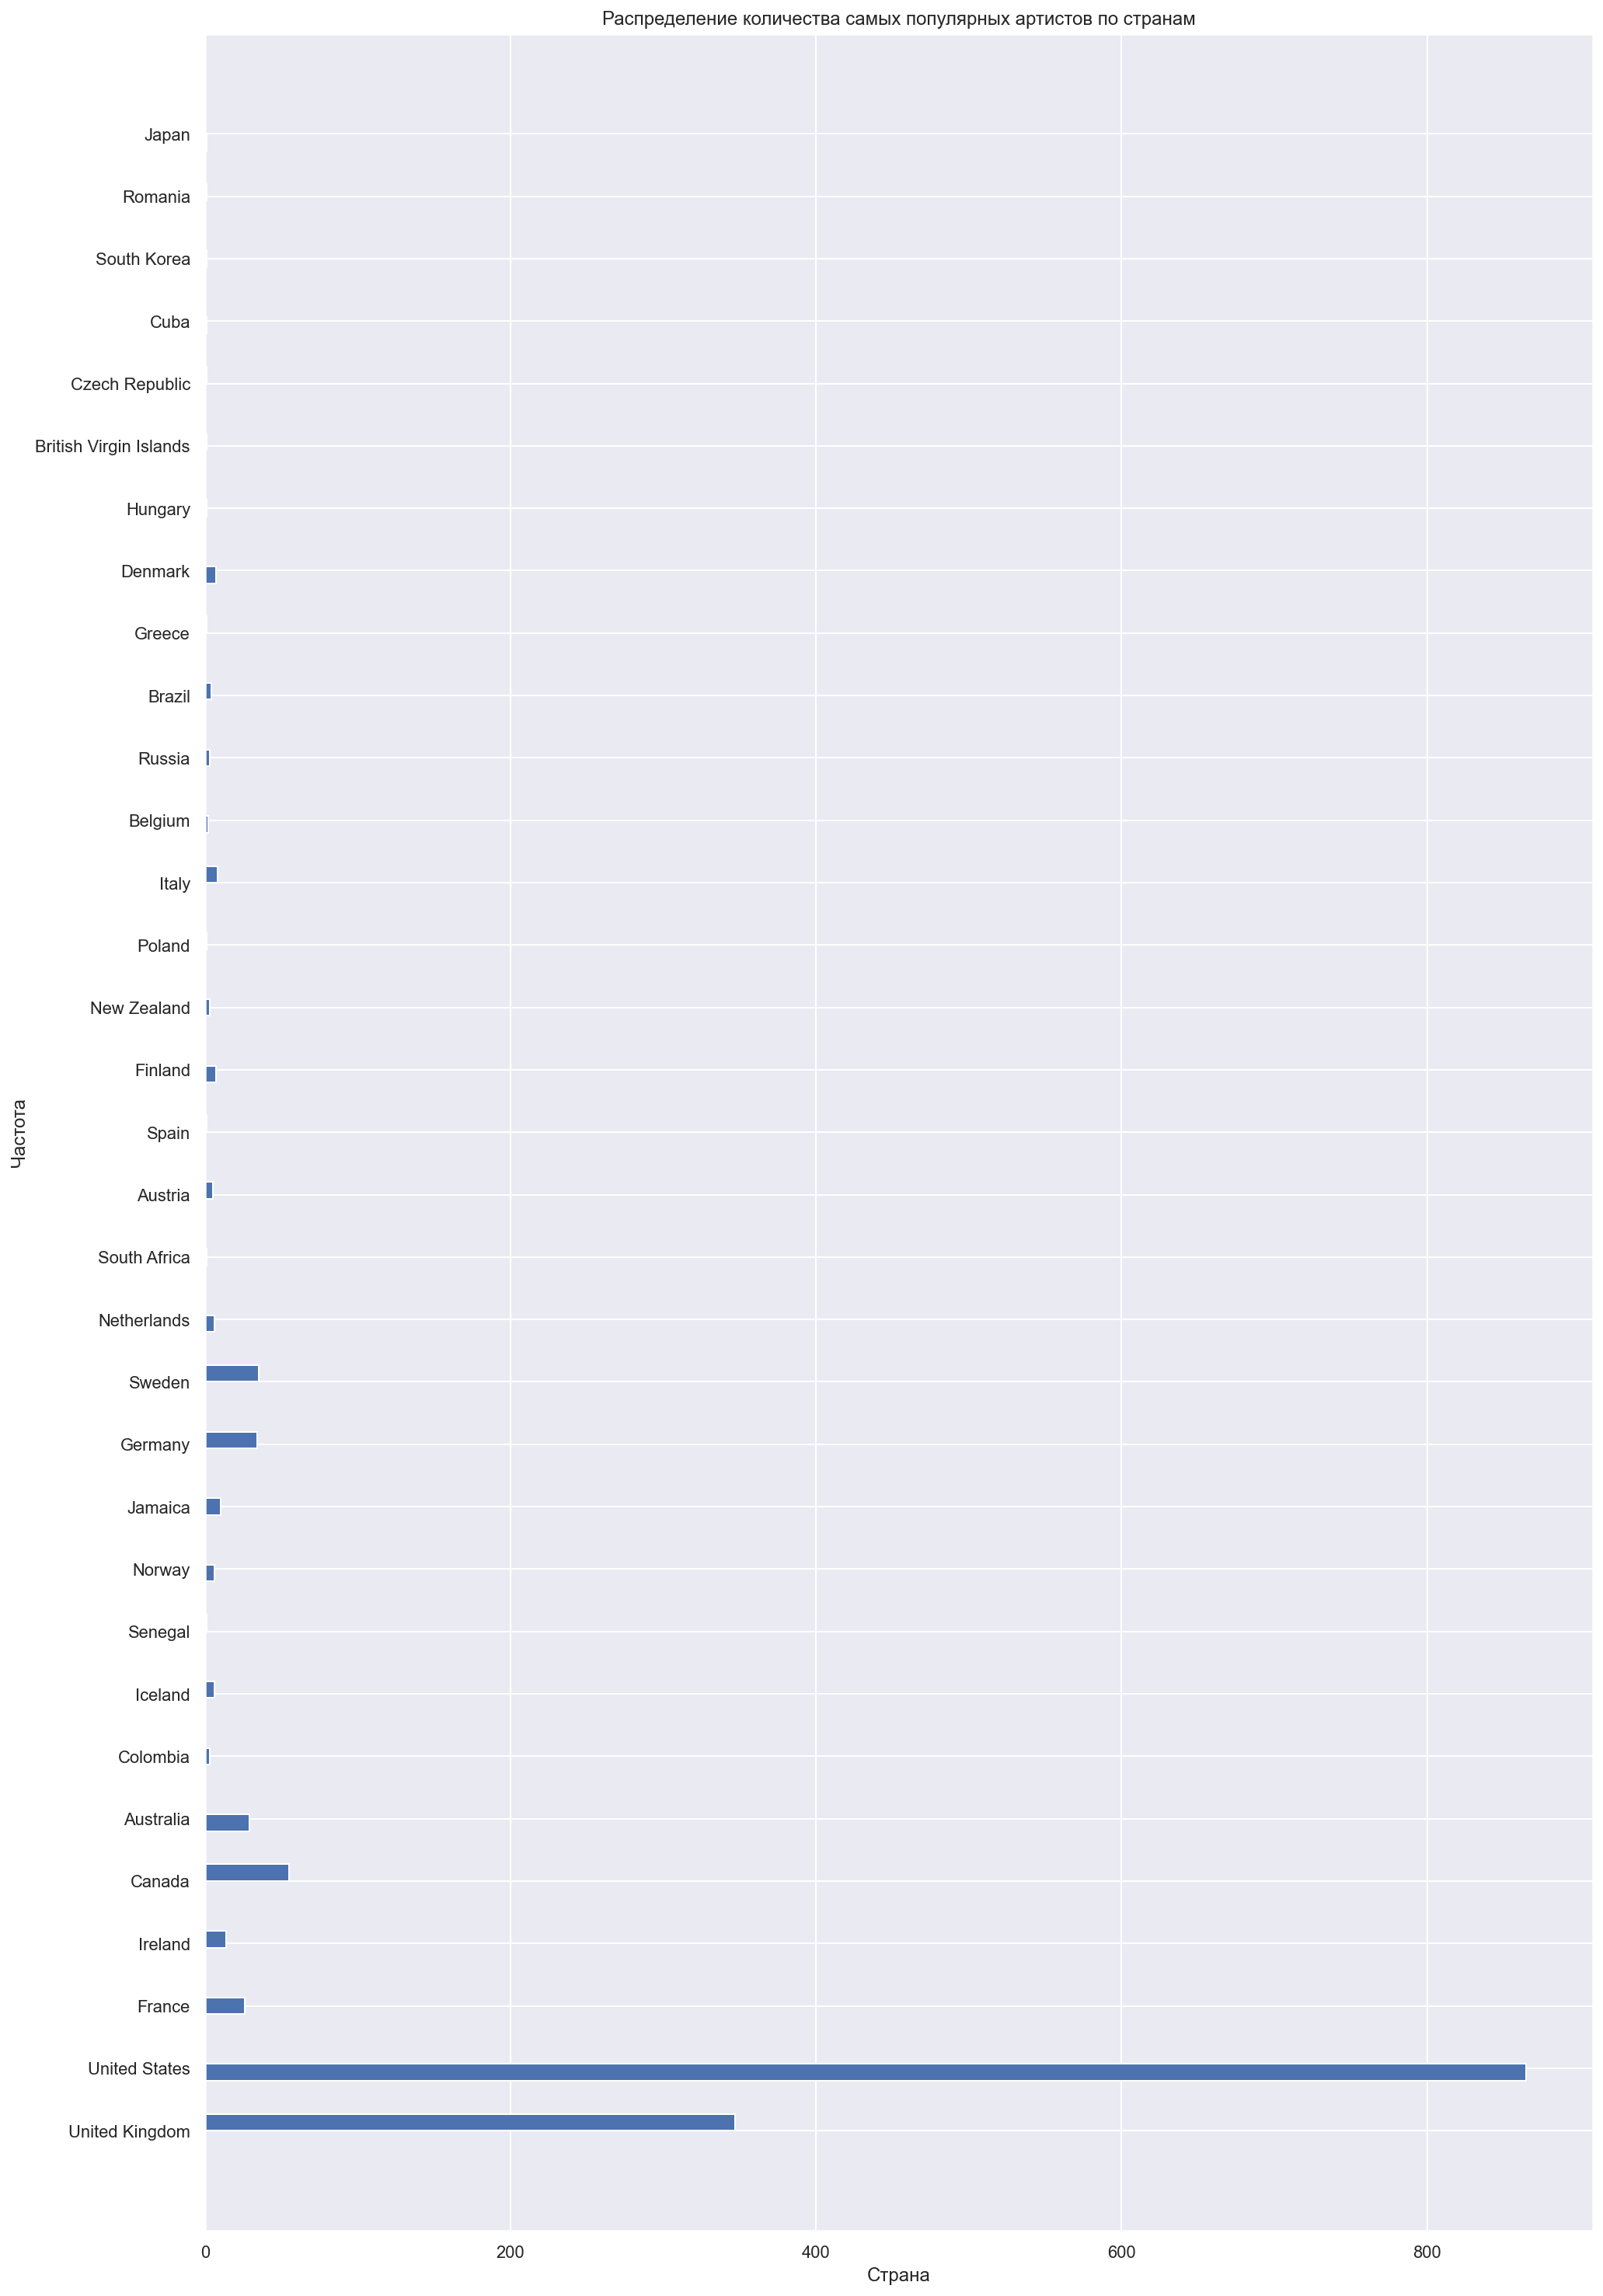

In [115]:
df_res_interim['country_mb'].hist(orientation='horizontal', figsize=(16, 26), bins = 120)

# добавляем заголовок и подписи осей
plt.title('Распределение количества самых популярных артистов по странам')
plt.xlabel('Страна')
plt.ylabel('Частота')

# выводим гистограмму на экран
plt.show()

Из выборки, которую мы взяли для проекта, видим, что большинство популярных артистов из США.


Давайте теперь посмотрим на гистограмму не самых популярных артистов, а в целом по всем исполнителям.

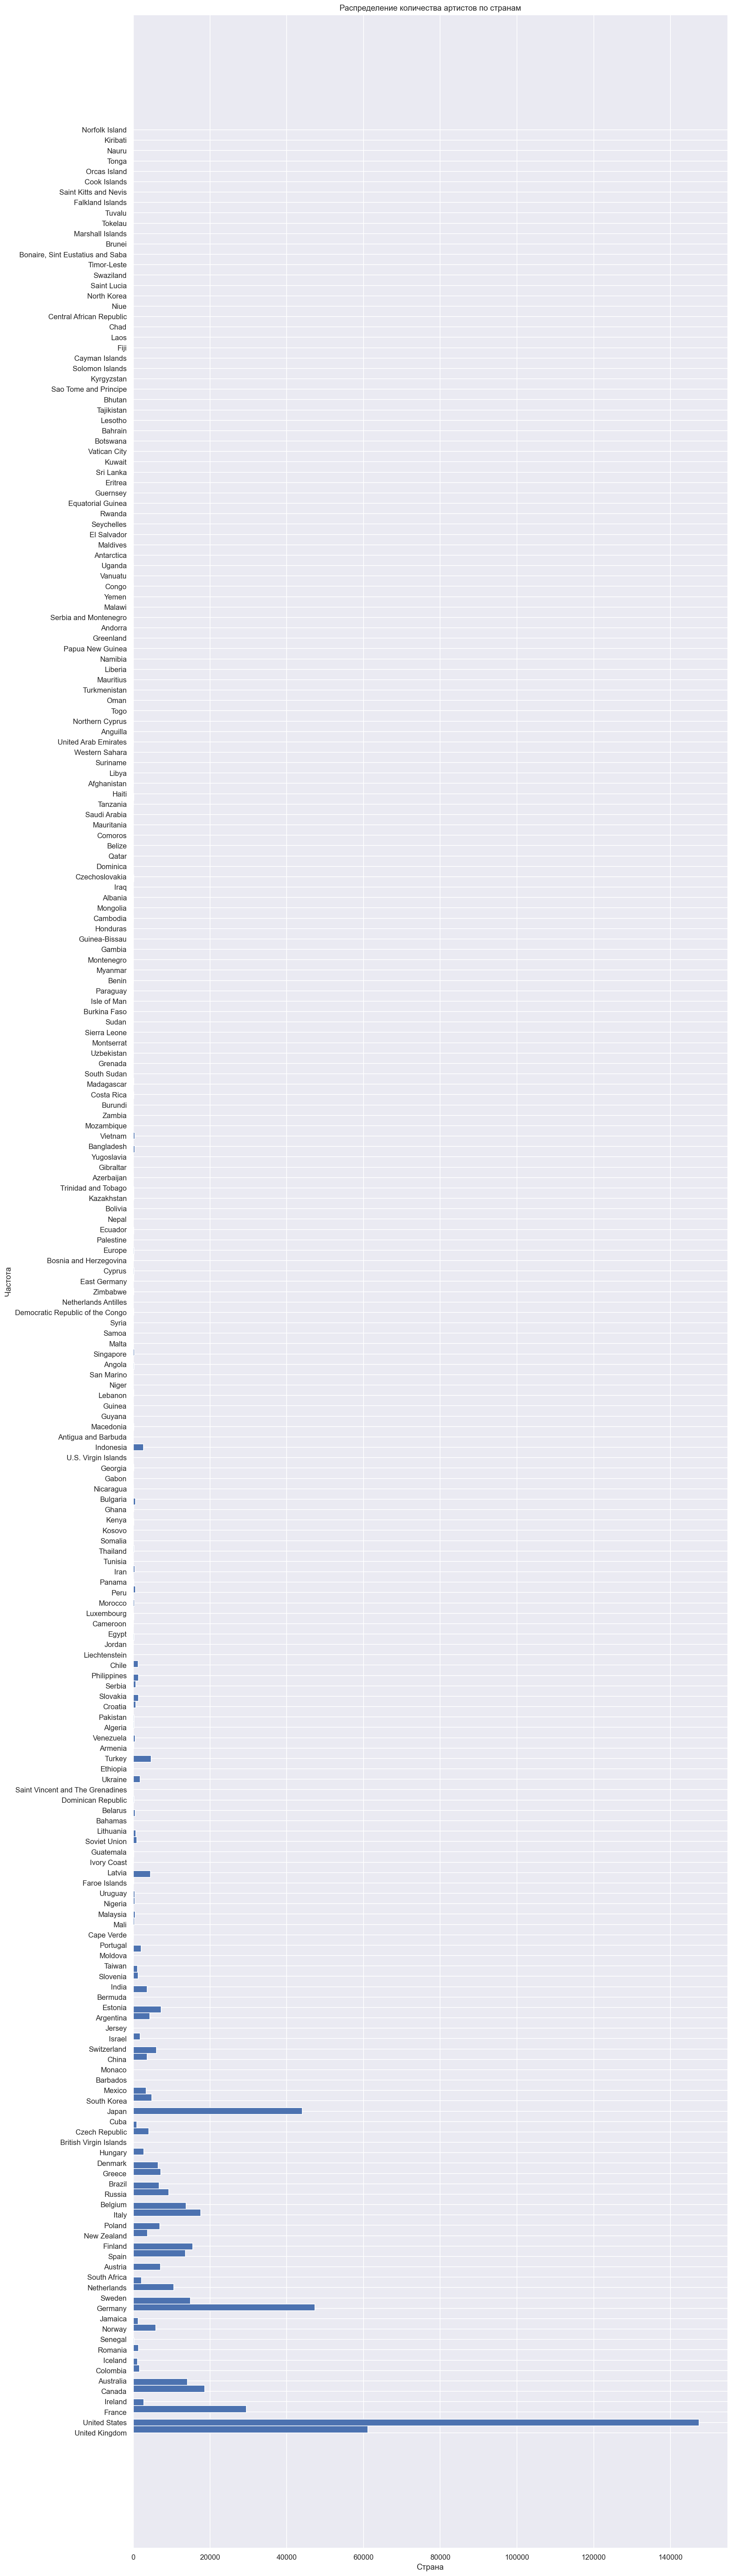

In [116]:
df['country_mb'].hist(orientation='horizontal', figsize=(16, 70), bins = 340)
                          
# добавляем заголовок и подписи осей
plt.title('Распределение количества артистов по странам')
plt.xlabel('Страна')
plt.ylabel('Частота')

# выводим гистограмму на экран
plt.show()

Если посмотреть на всех артистов, то можно увидеть, что все также большинство из США.

Построим гистограммы распределения по количеству

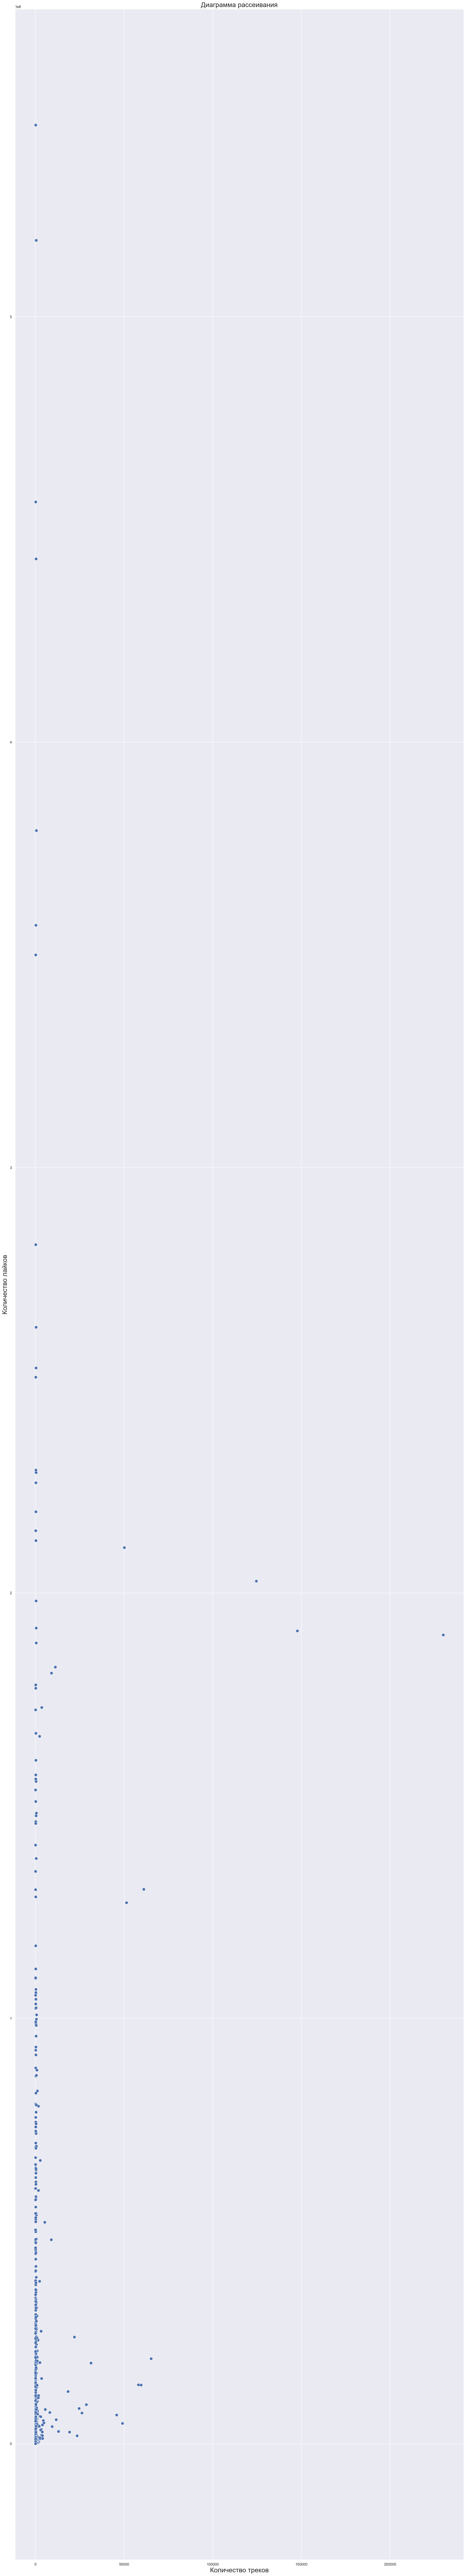

In [117]:
plt.figure(figsize=(24, 140))
sns.scatterplot(x=(df_res_interim['Количество треков']), y=df_res_interim['Количество лайков'], s=80)

plt.xlabel("Количество треков", fontsize=20)
plt.ylabel("Количество лайков", fontsize=20)
plt.title('Диаграмма рассеивания', fontsize=20)

plt.show();

Получилось что-то непонятное, давайте попробуем взять логарифм от количества треков.

In [126]:
plt.figure(figsize=(24, 140))
sns.scatterplot(x=np.log1p(df_res_interim['Количество треков']), y=df_res_interim['Количество лайков'], s=80)

plt.xlabel("Количество треков", fontsize=20)
plt.ylabel("Количество лайков", fontsize=20)
plt.title('Диаграмма рассеивания', fontsize=20)

plt.show();

TypeError: loop of ufunc does not support argument 0 of type int which has no callable log1p method

<Figure size 1728x10080 with 0 Axes>

График стал выглядеть более адекватным.

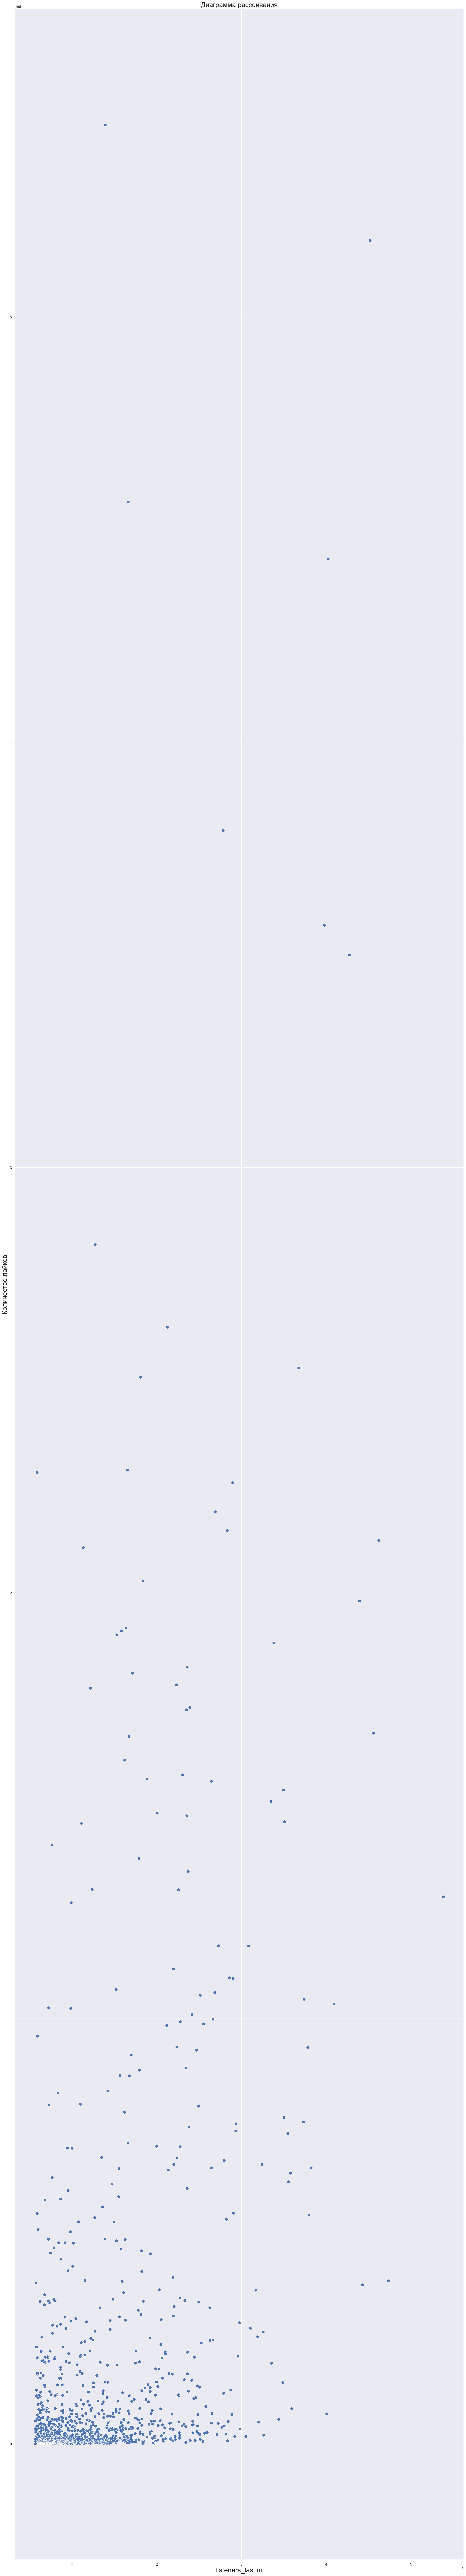

In [122]:
plt.figure(figsize=(24, 140))
sns.scatterplot(x=df_res_interim['listeners_lastfm'], y=df_res_interim['Количество лайков'], s=80)

plt.xlabel("listeners_lastfm", fontsize=20)
plt.ylabel("Количество лайков", fontsize=20)
plt.title('Диаграмма рассеивания', fontsize=20)

plt.show();

Очень много выбросов, которые мешают нормально построить график.